In [1]:
### original code AFZ Aug 2023; edits DAP May 2024
### occasional assistance from Claude 3 Opus ("C3O")
### refactoring with as much numpy as possible; largely eliminating CSV calls
### 10.1002/chem.200802192; subset for Ru-cat. transfer hydrogenation

import os
import re
import natsort
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

import cclib # not using RDKit yet...
import ccheminfolib
from ccheminfolib import cchemlib as ccl
import molli

from factor_analyzer import FactorAnalyzer
from factor_analyzer import calculate_kmo
from factor_analyzer import calculate_bartlett_sphericity

from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

user = '/Users/davidpolefrone/'
os.chdir('../factor_analysis/')
cwd = os.getcwd()
print(cwd)

/Users/davidpolefrone/factor_analysis


In [2]:
### Pickled gridfile (via python2) where the gridpoints are in the same order as the features. 
### It's a dict of ccl.datatypes.Gridpoints; need ccheminfolib (from Denmark lab, soon to be obsolete) to open.
with open('AA_grid.grid', 'rb') as gridfile:
    grid = pickle.load(gridfile, encoding='latin1')
    
data_file = open('Data.csv')
y_dict = {} # ddG for enantiomeric excess
for line in data_file.readlines():
    splitter = line.strip().split(',')
    y_dict[splitter[0]] = float(splitter[4])
data_file.close()

### Load the raw ASO.
f = open('ASO.csv','r')
X, label = [],[]
for line in f.readlines():
    splitter = line.strip().split(',')
    label.append(splitter[0]) # label: catalyst number
    X.append([float(x) for x in splitter[1:-1]])  # -1 due to line-ending commas
f.close()
print('number of gridpoints =',len(X[0]))
X = np.array(X) # 319 x 10318

number of gridpoints = 10318


In [3]:
len(data_file[0])

TypeError: '_io.TextIOWrapper' object is not subscriptable

In [7]:
########## Helper function section. 
### Simple method to read in these non-standard .xyz files.
def parse_cartesian(xyzfile):
    xyz = open(xyzfile)
    atom_symbol, coords = [],[]
    for line in xyz:
        atom,x,y,z = line.split()
        atom_symbol.append(atom)
        coords.append([float(x),float(y),float(z)])
    xyz.close()
    return atom_symbol, coords

### Initial fn from C3O; gets coordinates which align (within small tolerance value).
def find_matching_coordinates(lists, tolerance=0.05):
    def is_within_tolerance(coord1, coord2):
        return sum((a - b) ** 2 for a, b in zip(coord1, coord2)) ** 0.5 <= tolerance

    matching_coordinates = []
    for ref_coord in lists[0]:
        if all(any(is_within_tolerance(ref_coord, coord) for coord in coords) for coords in lists[1:]):
            matching_coordinates.append(ref_coord)
    return matching_coordinates

# Refactor of sklearn's VarianceThreshold.
def var_filter(idxs, array, var):
    var_thres = np.var(array[...,:], axis=0) > var # arbitrary units for var
    array = array[:,var_thres]; idxs = idxs[var_thres]
    return array, idxs

# Same as before, just a function now. 
def corr_filter(idxs, array, corr=0.90): 
    df = pd.DataFrame(array)
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)) # get top half of correlation matrix
    to_drop = [column for column in upper.columns if any(upper[column] > corr)] # if any number in a column is greater than 0.90, put that index in a list
    df.drop(to_drop, axis=1, inplace=True) # remove the highly correlated columns
    array_nocorr = df.to_numpy()
    
    idxs_ref = []
    for i in range(len(idxs)):
        if i in to_drop: pass
        else: idxs_ref.append(idxs[i])
    return array_nocorr, idxs_ref

def get_grid_coords(grid, idxs):
    coords_x = []; coords_y = []; coords_z = []
    for g in grid.keys():
        if g in retained_idxs2:
            coords_x.append(grid[g].coord.x)
            coords_y.append(grid[g].coord.y)
            coords_z.append(grid[g].coord.z)
    return (coords_x, coords_y, coords_z)

In [8]:
### Setup to read in the .xyz files used for ASO construction.
os.chdir(user+'factor_analysis/separated_aligned_xyz') # n=3,121
xyzfiles = []; prefixes = [] # corresponding to labels
for file in natsort.natsorted(os.listdir(os.getcwd())):
    if file.endswith('.xyz'):
        xyzfiles.append(file)
        prefixes.append('_'.join(file.split('_', 2)[:2])) # get everything before second underscore
prefixes = natsort.natsorted(list(set(prefixes))) # efficient removal of duplicates + sorting

In [9]:
### Now read in the .xyz files.
atom_symbol_lists, coords_lists = [],[] # these end up being lists of lists
for x in xyzfiles:
    sym, crds = parse_cartesian(x)
    sym = [re.match(r'[^0-9]*', s).group() for s in sym] # get just the symbols, not the numbers
    atom_symbol_lists.append(sym)
    coords_lists.append(crds)

In [10]:
### End the coordinate extraction section.
matched_coords = find_matching_coordinates(coords_lists) # index 0, index 9 from 1_1_0.xyz (O, N respectively) 
C1_coords = coords_lists[0][1]
C3_coords = coords_lists[0][3]
C5_coords = coords_lists[0][5]
os.chdir(user+'factor_analysis')

In [11]:
### Now time to remove features with minimal variance.
grid_idxs = np.ravel(range(0, len(X[0]))) 
X_red, reduced_idxs1 = var_filter(grid_idxs, X, var=0.03) # var is a tuned parameter (based on Bartlett/KMO).
print('number of retained gridpoints after variance threshold =',len(X_red[0])) 
# 330 @ var=0.03, 763 @ var=0.01, 986 @ var=0.005

number of retained gridpoints after variance threshold = 330


In [12]:
X_nocorr, retained_idxs2 = corr_filter(reduced_idxs1, X_red)
print('number of retained gridpoints after removing correlated gridpoints =',len(X_nocorr[0]))
# Corr 0.90: 159 @ var=0.03, 473 @ var=0.01, 644 @ var=0.005
# Corr 0.95: 237 @ var=0.03, 631 @ var=0.01, 847 @ var=0.005
### New model construction with corr=0.95, var=0.03 (237). Essentially the same thing. 

number of retained gridpoints after removing correlated gridpoints = 159


In [13]:
coords_x, coords_y, coords_z = get_grid_coords(grid, retained_idxs2)

In [16]:
X_nocorr.shape # (319, 159)

(319, 159)

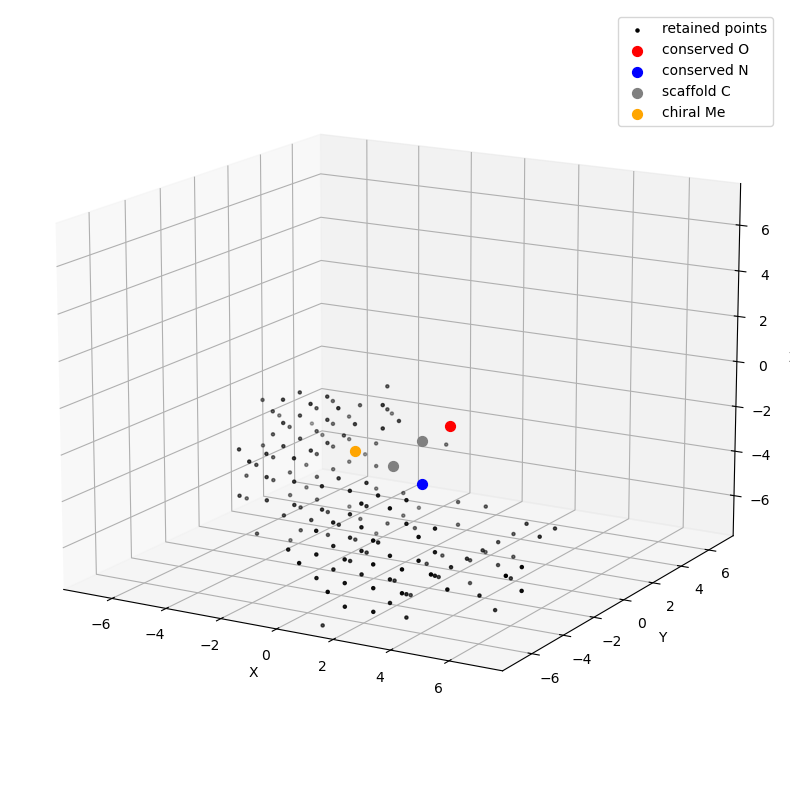

In [14]:
### Plot the truncated grid (after variance + correlation filters).
### Updated: truncated grid ft. O/N!
plt.rcParams['figure.figsize'] = [10, 10]
ax = plt.figure().add_subplot(projection='3d')

ax.scatter(coords_x, coords_y, coords_z, label='retained points', s=5, c='black')

ax.scatter(*zip(matched_coords[0]), label='conserved O', s=50, c='red')
ax.scatter(*zip(matched_coords[1]), label='conserved N', s=50, c='blue')
ax.scatter(*zip(C1_coords), label='scaffold C', s=50, c='gray')
ax.scatter(*zip(C3_coords), s=50, c='gray')
ax.scatter(*zip(C5_coords), label='chiral Me', s=50, c='orange')

ll = -7.5; ul = 7.5
ax.legend()
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_xlim(ll, ul); ax.set_ylim(ll, ul); ax.set_zlim(ll, ul)
ax.elev = 15
#ax.azim = 180

plt.show() 

In [208]:
teststat,p = calculate_bartlett_sphericity(X_nocorr) ### Bartlett sphericity to make sure we can compress it. 
print('Bartlett: ', teststat, '\n\tp value: ', p)
kmo_all, kmo_model = calculate_kmo(X_nocorr) ### KMO for factor analysis suitability.
print('KMO: ', kmo_model)

Bartlett:  120385.74595592705 
	p value:  0.0
KMO:  0.8886143869650089


/Users/davidpolefrone/anaconda3/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [277]:
### Results for a variety of models now. All scores are R^2 values. 
k=4	# Four-fold cross-validation.
print(f'k-fold score using OLSReg w/ raw features = {sum(cross_val_score(LinearRegression(), X_nofactor_train, y_train, cv=k))/k:.4f}')
print(f'k-fold score using Random Forest w/ raw features = {sum(cross_val_score(RandomForestRegressor(random_state=1234), X_nofactor_train, y_train, cv=k))/k:.4f}')

k-fold score using OLSReg w/ raw features = 0.5939
k-fold score using Random Forest w/ raw features = 0.8644


In [283]:
print(f'k-fold score using PLSReg (ncomp=16) = {sum(cross_val_score(PLSRegression(n_components=number_of_factors), X_nofactor_train, y_train, cv=k))/k:.4f}')
### Does n_components have to be set to the same as number_of factors?
model = PLSRegression(n_components=number_of_factors).fit(X_nofactor_train,y_train) 
X_pls_lv_train = model.transform(X_nofactor_train)
X_pls_lv_test = model.transform(X_nofactor_test)
print(f'k-fold score using Random Forest w/ PLS16 LVs = {sum(cross_val_score(RandomForestRegressor(random_state=1234), X_pls_lv_train, y_train, cv=k))/k:.4f}') 

k-fold score using PLSReg (ncomp=16) = 0.7256
k-fold score using Random Forest w/ PLS16 LVs = 0.8646


In [1]:
### PLS-based models plotted against many different n_components. 
plt.rcParams['figure.figsize'] = [20, 10]
fig = plt.figure()
ax = fig.add_subplot(111)

pls_cv_list, rf_cv_list = [],[]
for i in range(2, 40):
    pls_cv = sum(cross_val_score(PLSRegression(n_components=i), X_nofactor_train, y_train, cv=k))/k
    pls_mod = PLSRegression(n_components=i).fit(X_nofactor_train,y_train)
    X_plsLV_trn = pls_mod.transform(X_nofactor_train)
    X_plsLV_tst = pls_mod.transform(X_nofactor_test)
    rf_cv = sum(cross_val_score(RandomForestRegressor(random_state=1234), X_plsLV_trn, y_train, cv=k))/k
    pls_cv_list.append(pls_cv); rf_cv_list.append(rf_cv)

x_ax = np.ravel(range(2,40))
ax.scatter(x_ax, pls_cv_list, c='black', label='PLS R2')
ax.scatter(x_ax, rf_cv_list, c='blue', label='RF R2')
ax.legend()
ax.set_title('4-fold R2 as a function of n_components')
plt.show()

NameError: name 'plt' is not defined

In [321]:
### Complex for-loop: how do FA-based model scores vary as a function of # of factors?
### Takes ~3min to run.
X_factor_list, y_list = [],[]
X_factor_train_list, X_factor_test_list = [],[]
y_train_list, y_test_list = [],[]
olsFA_cv_list, rfFA_cv_list, lsFA_cv_list, rgFA_cv_list, enFA_cv_list = [],[],[],[],[]

for i in range(2, 40):
    fa_mod = FactorAnalyzer(n_factors=i,rotation="varimax")
    fa_mod.fit(X_nocorr)
    X_faLV = fa_mod.transform(X_nocorr) 
    
    X_factor, y = [],[]
    for l in range(len(label)):
        if label[l] in y_dict.keys():
            X_factor.append(X_faLV[l])
            y.append(y_dict[label[l]])
            
    scaler = StandardScaler()
    X_factor = scaler.fit_transform(X_factor) # 1/6 used for cross-validation (why?).
    X_factor_train, X_factor_test, y_train, y_test = train_test_split(X_factor, y, 
                                                        test_size=0.166666666666666, random_state=42)
    
    X_factor_list.append(X_factor); y_list.append(y)
    X_factor_train_list.append(X_factor_train); X_factor_test_list.append(X_factor_test)
    y_train_list.append(y_train); y_test_list.append(y_test)
    
    olsFA_cv_list.append(sum(cross_val_score(LinearRegression(), X_factor_train, y_train, cv=k))/k)
    rfFA_cv_list.append(sum(cross_val_score(RandomForestRegressor(random_state=1234), X_factor_train, y_train, cv=k))/k)
    lsFA_cv_list.append(sum(cross_val_score(LassoCV(), X_factor_train, y_train, cv=k))/k)
    rgFA_cv_list.append(sum(cross_val_score(RidgeCV(), X_factor_train, y_train, cv=k))/k)
    enFA_cv_list.append(sum(cross_val_score(ElasticNetCV(), X_factor_train, y_train, cv=k))/k)

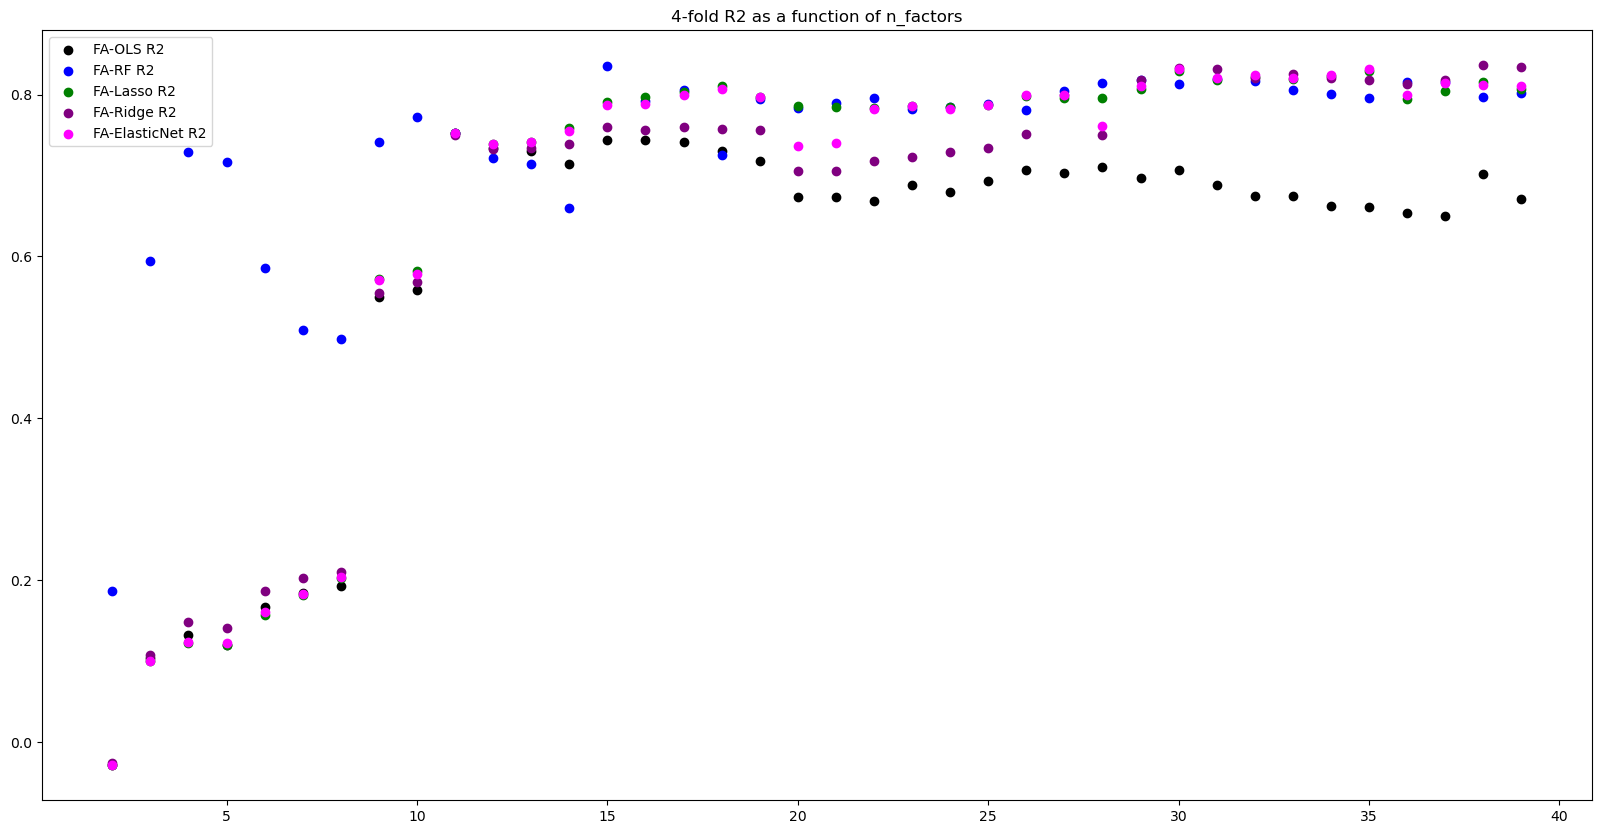

In [340]:
plt.rcParams['figure.figsize'] = [20, 10]
fig = plt.figure()
ax = fig.add_subplot(111)

x_ax = np.ravel(range(2,40))
ax.scatter(x_ax, olsFA_cv_list, c='black', label='FA-OLS R2')
ax.scatter(x_ax, rfFA_cv_list, c='blue', label='FA-RF R2')
ax.scatter(x_ax, lsFA_cv_list, c='green', label='FA-Lasso R2')
ax.scatter(x_ax, rgFA_cv_list, c='purple', label='FA-Ridge R2')
ax.scatter(x_ax, enFA_cv_list, c='magenta', label='FA-ElasticNet R2')
ax.legend()
ax.set_title('4-fold R2 as a function of n_factors')
plt.show()

In [328]:
### Actually doing factor analysis: first we need to figure out how many factors to use.
factor_model = FactorAnalyzer(n_factors=len(X_nocorr[0]),rotation="varimax")
factor_model.fit(X_nocorr) 
eigenvalues, _ = factor_model.get_eigenvalues()
number_of_factors = sum(eigenvalues > 1) 
factor_model = FactorAnalyzer(n_factors=number_of_factors,rotation="varimax")
factor_model.fit(X_nocorr)
print('Number of factors selected = ', number_of_factors)

Number of factors selected =  16


In [329]:
### Now trying to make models with the FA latent variables to see if they're worth trying to interpret.
### We don't have data for all the catalysts, so we need to filter these.
### Including these other ones actually changes the analysis, but ideally we'd go for as many
### catalysts as posible so the transform is more general.
X_latent = factor_model.transform(X_nocorr)
X_factor = []; X_nofactor = []
labels_final = []; y = []

for i in range(len(label)):
    if label[i] in y_dict.keys():
        X_factor.append(X_latent[i])
        X_nofactor.append(X_nocorr[i])
        y.append(y_dict[label[i]])
        labels_final.append(label[i])
        
### Scaling these so we can interpret coefficients later on.
scaler = StandardScaler()
X_factor = scaler.fit_transform(X_factor) # 1/6 used for cross-validation (why?).
X_factor_train, X_factor_test, y_train, y_test = train_test_split(X_factor, y, 
                                                                  test_size=0.166666666666666, random_state=42)
X_nofactor_train, X_nofactor_test, y_train, y_test = train_test_split(X_nofactor, y, 
                                                                      test_size=0.166666666666666, random_state=42)

In [330]:
print(f'k-fold score using OLSReg w/ FA LVs = {sum(cross_val_score(LinearRegression(), X_factor_train, y_train, cv=k))/k:.4f}')
print(f'k-fold score using Random Forest w/ FA LVs = {sum(cross_val_score(RandomForestRegressor(random_state=1234), X_factor_train, y_train, cv=k))/k:.4f}')
print(f'k-fold score using LassoCV w/ FA LVs = {sum(cross_val_score(LassoCV(), X_factor_train, y_train, cv=k))/k:.4f}')
print(f'k-fold score using RidgeCV w/ FA LVs = {sum(cross_val_score(RidgeCV(), X_factor_train, y_train, cv=k))/k:.4f}')
print(f'k-fold score using ElasticNetCV w/ FA LVs = {sum(cross_val_score(ElasticNetCV(), X_factor_train, y_train, cv=k))/k:.4f}')

k-fold score using OLSReg w/ FA LVs = 0.7441
k-fold score using Random Forest w/ FA LVs = 0.7924
k-fold score using LassoCV w/ FA LVs = 0.7966
k-fold score using RidgeCV w/ FA LVs = 0.7568
k-fold score using ElasticNetCV w/ FA LVs = 0.7888


In [339]:
### Interpretation time!

rfe = LinearRegression()
rfe = RFECV(rfe, step=1, cv=5)
rfe = rfe.fit(X_factor_train, y_train)
X_reduced_factors_train = rfe.transform(X_factor_train)
X_reduced_factors_test = rfe.transform(X_factor_test) # note this yields four top factors (see below).

### OLS improves quite a bit, which is the point. Also, RF improves marginally. 
print(f'k-fold score using OLSReg w/ FA after RFE = {sum(cross_val_score(LinearRegression(), X_reduced_factors_train, y_train, cv=k))/k:.4f}')
print(f'k-fold score using RF w/ FA after RFE = {sum(cross_val_score(RandomForestRegressor(random_state=1234), X_reduced_factors_train, y_train, cv=k))/k:.4f}')
print(f'k-fold score using LassoCV w/ FA after RFE = {sum(cross_val_score(LassoCV(), X_reduced_factors_train, y_train, cv=k))/k:.4f}')

reduced_model = LinearRegression().fit(X_reduced_factors_train,y_train)
train_set_preds_reduced = reduced_model.predict(X_reduced_factors_train)
test_set_preds_reduced = reduced_model.predict(X_reduced_factors_test)

k-fold score using OLSReg w/ FA after RFE = 0.8131
k-fold score using RF w/ FA after RFE = 0.7980
k-fold score using LassoCV w/ FA after RFE = 0.8133


In [237]:
### Assigning each gridpoint to a factor on the basis of highest loadings.
loading_matrix = factor_model.loadings_	# (159, 16)
factor_assignments = []	
for e in loading_matrix:
    max_loading = -1000000; best_idx = -1000000
    for i in range(len(e)):
        if abs(e[i]) > max_loading:
            max_loading = abs(e[i]); best_idx = i
    factor_assignments.append(best_idx)

kept_list = list(rfe.support_) 
kept_factors = []
for i in range(len(kept_list)):
    if kept_list[i] == False: pass
    else: kept_factors.append(i) # kept factors: 0, 1, 7, 9

In [238]:
### 63 indices correspond to these top-4 factors. 
FA_grid_dict = {}
FA_coords_x, FA_coords_y, FA_coords_z = [], [], []
FA_label = []
retained_indices_3 = []
for i in range(len(factor_assignments)):
    if factor_assignments[i] in kept_factors:
        coords = [coords_x[i],coords_y[i],coords_z[i]]
        FA_coords_x.append(coords_x[i])
        FA_coords_y.append(coords_y[i])
        FA_coords_z.append(coords_z[i])
        FA_label.append(factor_assignments[i])
        retained_indices_3.append(retained_idxs2[i])
### NumPy helps quite a bit below. 
FA_coords_x = np.array(FA_coords_x)
FA_coords_y = np.array(FA_coords_y)
FA_coords_z = np.array(FA_coords_z)
FA_label = np.array(FA_label)
arrays_by_factor = [np.where(FA_label == kf) for kf in kept_factors]

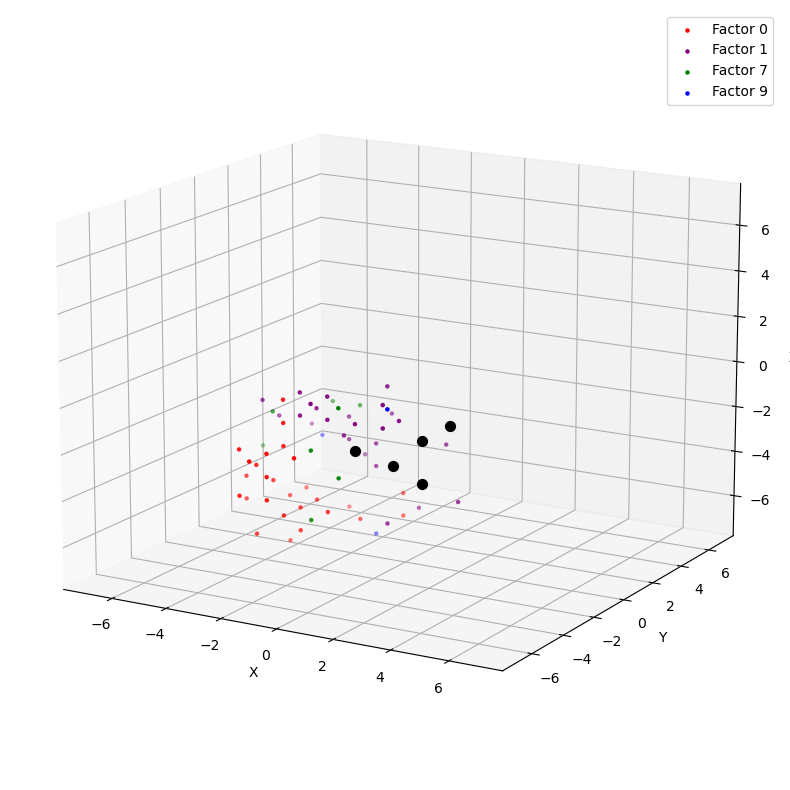

[-0.06729779  0.17447346 -0.14148297 -0.35150887]


In [225]:
### Plot the FA-processed grid, etc.
plt.rcParams['figure.figsize'] = [10, 10]
ax = plt.figure().add_subplot(projection='3d')
c = FA_label
cmhot = plt.get_cmap("Set1")

cols = ['red', 'purple', 'green', 'blue']
for f in range(len(kept_factors)): 
    idxs = arrays_by_factor[f]
    ax.scatter(FA_coords_x[idxs], FA_coords_y[idxs], FA_coords_z[idxs], 
               c=cols[f], label=f'Factor {kept_factors[f]}', s=5)

ax.legend()
ax.scatter(*zip(matched_coords[0]), label='conserved O', s=50, c='black')
ax.scatter(*zip(matched_coords[1]), label='conserved N', s=50, c='black')
ax.scatter(*zip(C1_coords), label='scaffold C', s=50, c='black')
ax.scatter(*zip(C3_coords), s=50, c='black')
ax.scatter(*zip(C5_coords), label='chiral Me', s=50, c='black')

ll = -7.5; ul = 7.5
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_xlim(ll, ul); ax.set_ylim(ll, ul); ax.set_zlim(ll, ul)
ax.elev = 15
#ax.azim = 180

plt.show() 
coeffs = reduced_model.coef_
print(coeffs) # Put coefs next to factors in plot

In [ ]:
#########################################################################

In [92]:
# FINISH REFACTORING!
#########################################################################
### Remove features with high pairwise correlation. 
corr_matrix = np.abs(np.corrcoef(X_red.transpose())) # use transpose to get column correlations
upper = np.where(np.triu(np.ones(corr_matrix.shape), k=1), corr_matrix, 0) # get top half of correlation matrix 
to_drop = np.where(np.any(upper > 0.90, axis=0))[0] 
to_keep = np.where(np.any(upper <= 0.90, axis=0))[0] 

### NOTE: This will just drop the first of the correlated variables in the order they appear. 
### There is probably a way to drop the one that is least correlated with the target, 
### but they contain the ~same information and correlation is likely amongst neighbors, so it won't 
### change the interpretation at the end. If that assumption isn't true we might need to rethink how we drop one. 
### This was also tuned accoring to maximizing the KMO score (below)
X_nocorr = X_red[:,to_keep]
retained_idxs = reduced_idxs1[to_keep]
print('number of retained gridpoints after removing correlated gridpoints =',len(X_nocorr[0]))
# Corr 0.90: 159 @ var=0.03, 473 @ var=0.01, 644 @ var=0.005
# Corr 0.95: 237 @ var=0.03, 631 @ var=0.01, 847 @ var=0.005

number of retained gridpoints after removing correlated gridpoints = 763
